### This notebook is used to create chunks of the original data
The chunking splits longer audio clips into short segments. The segments are created with overlap. The signla to noise ratio is used to determine which chunks have bird song in them and which are just noise. Some the noise chunks are saved and used in training.

In [17]:
import numpy as np
import pandas as pd
import random
import math

import os
from pathlib import Path
import shutil

import cv2
from tqdm import tqdm

from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

#### Signla to Noise function

In [2]:
def signal2noise_logspec_median(spec, freq_margin_db=10.0, time_margin_db=10.0):
    """
    Estimate SNR for a log-mel spectrogram by applying median-based thresholds
    along frequency (rows) and time (columns), with morphological cleaning.
    
    Args:
        spec (np.ndarray): Log-mel spectrogram (shape: [n_mels, time_frames], in dB)
        freq_margin_db (float): Margin above freq median for thresholding (dB)
        time_margin_db (float): Margin above time median for thresholding (dB)
        
    Returns:
        s2n (float): Estimated signal-to-noise ratio in [0,1]
    """
    spec = spec.copy()

    # Median per frequency bin (row-wise median over time)
    row_median = np.median(spec, axis=1, keepdims=True)  # shape (n_mels, 1)
    # Median per time frame (column-wise median over freq)
    col_median = np.median(spec, axis=0, keepdims=True)  # shape (1, time_frames)

    # Create masks where values exceed median + margin
    freq_mask = spec >= (row_median + freq_margin_db)
    time_mask = spec >= (col_median + time_margin_db)



    # Combine masks: pixel counts as signal if above both frequency and time thresholds
    combined_mask = np.logical_and(freq_mask, time_mask).astype(np.uint8)  # binary mask 0/1

    # Median blur to reduce salt & pepper noise
    combined_mask = cv2.medianBlur(combined_mask, 3)

    # Morphological close to fill gaps
    kernel = np.ones((3, 3), np.uint8)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)

    # Calculate signal-to-noise ratio as fraction of signal pixels
    s2n = combined_mask.sum() / combined_mask.size

    return s2n

#### Test chunking on single file

In [3]:
def test_chunking_single_spectrogram(
    file_path,
    output_root,
    chunk_size=256,
    stride=64,
    snr_threshold=0.1,
    freq_margin_db = 10,
    time_margin_db = 10

):
    
    os.makedirs(output_root, exist_ok=True)

    metadata_records = []

    spec = np.load(file_path)
    num_frames = spec.shape[1]
    base_name = os.path.splitext(os.path.basename(file_path))[0]

    chunk_idx = 0

    for start in range(0, num_frames - chunk_size + 1, stride):
        chunk = spec[:, start:start + chunk_size]
        s2n = signal2noise_logspec_median(chunk, freq_margin_db, time_margin_db)

        print(f"Chunk {chunk_idx} | Start: {start} | SNR: {s2n:.4f}")

        #if s2n >= snr_threshold:
        chunk_filename = f"{base_name}_chunk{chunk_idx}.npy"
        chunk_path = os.path.join(output_root, chunk_filename)
        np.save(chunk_path, chunk)

        metadata_records.append({
            "chunk_index": chunk_idx,
            "start_frame": start,
            "end_frame": start + chunk_size,
            "snr": s2n,
            "chunk_path": chunk_path
        })

        chunk_idx += 1

    df = pd.DataFrame(metadata_records)
    metadata_path = os.path.join(output_root, f"{base_name}_metadata.csv")
    df.to_csv(metadata_path, index=False)
    print(f"\nSaved test metadata to {metadata_path}")

In [ ]:
test_chunking_single_spectrogram(
    file_path="../data/processed_audio/npy_spectrograms/Black Cuckoo/Black_Cuckoo_09.npy",
    output_root="../data/processed_audio/test_chunks",
    chunk_size=256,
    stride=64,
    snr_threshold=0.1
)

Chunk 0 | Start: 0 | SNR: 0.0122
Chunk 1 | Start: 128 | SNR: 0.0183
Chunk 2 | Start: 256 | SNR: 0.0210
Chunk 3 | Start: 384 | SNR: 0.0130
Chunk 4 | Start: 512 | SNR: 0.0109
Chunk 5 | Start: 640 | SNR: 0.0168
Chunk 6 | Start: 768 | SNR: 0.0132
Chunk 7 | Start: 896 | SNR: 0.0062
Chunk 8 | Start: 1024 | SNR: 0.0181
Chunk 9 | Start: 1152 | SNR: 0.0209
Chunk 10 | Start: 1280 | SNR: 0.0100
Chunk 11 | Start: 1408 | SNR: 0.0023
Chunk 12 | Start: 1536 | SNR: 0.0117
Chunk 13 | Start: 1664 | SNR: 0.0154
Chunk 14 | Start: 1792 | SNR: 0.0078
Chunk 15 | Start: 1920 | SNR: 0.0010
Chunk 16 | Start: 2048 | SNR: 0.0092
Chunk 17 | Start: 2176 | SNR: 0.0151

Saved test metadata to ../data/processed_audio/test_chunks/Black_Cuckoo_09_metadata.csv


#### Visualize Chunks
This will allow us to tune the snr_threshold, and the signal2noise function

In [4]:
def plot_chunks_from_metadata(metadata_csv, num_chunks=None):
    df = pd.read_csv(metadata_csv)
    df = df.sort_values(by="snr", ascending=False)

    if num_chunks is not None:
        df = df.head(num_chunks)

    total = len(df)
    cols = 5
    rows = math.ceil(total / cols)

    plt.figure(figsize=(3 * cols, 3 * rows))
    for i, (_, row) in enumerate(df.iterrows()):
        chunk = np.load(row["chunk_path"])
        plt.subplot(rows, cols, i + 1)
        plt.imshow(chunk, origin="lower", aspect="auto", cmap="magma")
        plt.title(f"SNR: {row['snr']:.4f}", fontsize=8)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

Chunk 0 | Start: 0 | SNR: 0.0054
Chunk 1 | Start: 64 | SNR: 0.0068
Chunk 2 | Start: 128 | SNR: 0.0093
Chunk 3 | Start: 192 | SNR: 0.0240
Chunk 4 | Start: 256 | SNR: 0.0259

Saved test metadata to ../data/processed_audio/test_chunks/Black_Cuckoo_01_metadata.csv


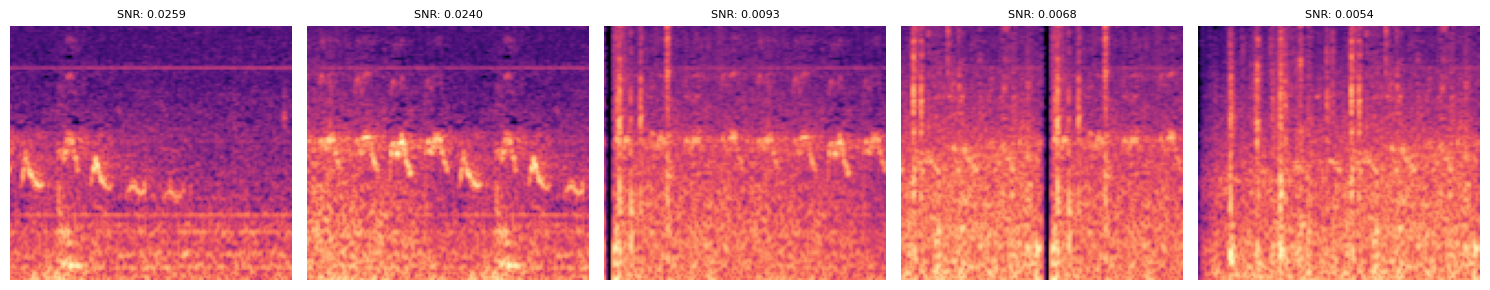

In [16]:
test_chunking_single_spectrogram(
    file_path="../data/processed_audio/npy_spectrograms/Black Cuckoo/Black_Cuckoo_01.npy",
    output_root="../data/processed_audio/test_chunks",
    chunk_size=128,
    stride=64,
    snr_threshold=0.1,
    freq_margin_db=10,
    time_margin_db = 10
)

plot_chunks_from_metadata('../data/processed_audio/test_chunks/Black_Cuckoo_01_metadata.csv')

In [18]:
def chunk_and_filter_spectrograms(
    input_root,
    output_root,
    metadata_path,
    chunk_size=86,
    stride=43,
    snr_threshold=0.01,
    noise_snr_threshold = 0.008,
    low_snr_keep_prob=0.1,
):
    os.makedirs(output_root, exist_ok=True)
    os.makedirs(os.path.dirname(metadata_path), exist_ok=True)

    metadata_records = []

    for species in tqdm(os.listdir(input_root)):
        species_dir = os.path.join(input_root, species)
        if not os.path.isdir(species_dir):
            continue

        for npy_file in os.listdir(species_dir):
            if not npy_file.endswith(".npy"):
                continue

            spec_path = os.path.join(species_dir, npy_file)
            spec = np.load(spec_path)

            num_frames = spec.shape[1]
            # Repeat if too short
            if num_frames < chunk_size:
                repeat_factor = int(np.ceil(chunk_size / num_frames))
                spec = np.tile(spec, (1, repeat_factor))  # Repeat along time axis
                spec = spec[:, :chunk_size]  # Trim to exact chunk size
                num_frames = chunk_size  # Update after repeating
            
            chunk_idx = 0

            # Create output folder name based on original file (no extension)
            orig_name = os.path.splitext(npy_file)[0]
            output_orig_dir = os.path.join(output_root, orig_name)
            noise_dir = os.path.join(output_root, "noise")

            for start in range(0, num_frames - chunk_size + 1, stride):
                chunk = spec[:, start:start + chunk_size]
                s2n = signal2noise_logspec_median(chunk)

                if s2n >= snr_threshold:
                    label = species
                    chunk_dir = output_orig_dir  # Save chunk in folder named after original file
                    save_chunk = True
                elif s2n <= noise_snr_threshold:
                    label = "noise"
                    chunk_dir = noise_dir  # Save noise chunks in separate noise folder
                    save_chunk = True
                #else:
                    # Low SNR chunk: keep as noise with probability
                    #if random.random() < low_snr_keep_prob:
                        #label = "noise"
                        #chunk_dir = noise_dir  # Save noise chunks in separate noise folder
                        #save_chunk = True
                    #else:
                        #save_chunk = False

                if save_chunk:
                    os.makedirs(chunk_dir, exist_ok=True)
                    chunk_filename = f"{orig_name}_chunk{chunk_idx}.npy"
                    chunk_path = os.path.join(chunk_dir, chunk_filename)
                    np.save(chunk_path, chunk)

                    metadata_records.append({
                        "original_file": npy_file,
                        "chunk_index": chunk_idx,
                        "start_frame": start,
                        "end_frame": start + chunk_size,
                        "snr": s2n,
                        "species": label,
                        "chunk_path": chunk_path
                    })

                    chunk_idx += 1

    df = pd.DataFrame(metadata_records)
    df.to_csv(metadata_path, index=False)
    print(f"\nSaved metadata to {metadata_path}")

In [32]:
def chunk_and_save_best_snr_only(
    input_root,
    output_root,
    metadata_path,
    chunk_size=86,
    stride=43,
):
    os.makedirs(output_root, exist_ok=True)
    os.makedirs(os.path.dirname(metadata_path), exist_ok=True)

    metadata_records = []

    for species in tqdm(os.listdir(input_root)):
        species_dir = os.path.join(input_root, species)
        if not os.path.isdir(species_dir):
            continue

        for npy_file in os.listdir(species_dir):
            if not npy_file.endswith(".npy"):
                continue

            spec_path = os.path.join(species_dir, npy_file)
            spec = np.load(spec_path)
            num_frames = spec.shape[1]

            # Repeat if too short
            if num_frames < chunk_size:
                repeat_factor = int(np.ceil(chunk_size / num_frames))
                spec = np.tile(spec, (1, repeat_factor))  # Repeat along time axis
                spec = spec[:, :chunk_size]  # Trim to exact chunk size
                num_frames = chunk_size  # Update after repeating

            best_chunk = None
            best_snr = -float("inf")
            best_start = None

            for start in range(0, num_frames - chunk_size + 1, stride):
                chunk = spec[:, start:start + chunk_size]
                s2n = signal2noise_logspec_median(chunk)

                if s2n > best_snr:
                    best_snr = s2n
                    best_chunk = chunk
                    best_start = start

            if best_chunk is not None:
                orig_name = os.path.splitext(npy_file)[0]
                chunk_dir = os.path.join(output_root, orig_name)
                os.makedirs(chunk_dir, exist_ok=True)

                chunk_filename = f"{orig_name}_bestchunk.npy"
                chunk_path = os.path.join(chunk_dir, chunk_filename)
                np.save(chunk_path, best_chunk)

                metadata_records.append({
                    "original_file": npy_file,
                    "chunk_index": "best",
                    "start_frame": best_start,
                    "end_frame": best_start + chunk_size,
                    "snr": best_snr,
                    "species": species,
                    "chunk_path": chunk_path
                })

    df = pd.DataFrame(metadata_records)
    df.to_csv(metadata_path, index=False)
    print(f"\nSaved metadata to {metadata_path}")


In [20]:

input_root = "../data/processed_audio/npy_spectrograms"
output_root = "../data/processed_audio/256f_chunked_spectrograms"
metadata_path = "../data/metadata/256f_chunked_metadata.csv"

chunk_and_filter_spectrograms(input_root, output_root, metadata_path, chunk_size=256, stride=64)

100%|██████████| 40/40 [01:26<00:00,  2.16s/it]



Saved metadata to ../data/metadata/256f_chunked_metadata.csv


In [19]:
# Source and destination directories
SRC_DIR = Path(input_root)
DEST_DIR = Path("../data/processed_audio/flattened_128f_chunked_spectrograms")
DEST_DIR.mkdir(exist_ok=True)

# Copy each .npy file from subdirectories into the new flat directory
for subdir in SRC_DIR.iterdir():
    if subdir.is_dir():
        for npy_file in subdir.glob("*.npy"):
            dest_path = DEST_DIR / npy_file.name
            shutil.copy2(npy_file, dest_path)


#### Inspect Metadata

In [21]:
chunk_metadata = pd.read_csv(metadata_path)
chunk_metadata.head()

original_file  chunk_index  start_frame  end_frame  \
0  Chestnut-vented_Warbler_34.npy            0            0        256   
1  Chestnut-vented_Warbler_34.npy            1           64        320   
2  Chestnut-vented_Warbler_34.npy            2          128        384   
3  Chestnut-vented_Warbler_34.npy            3          192        448   
4  Chestnut-vented_Warbler_34.npy            4          256        512   

        snr                  species  \
0  0.077911  Chestnut-vented Warbler   
1  0.114624  Chestnut-vented Warbler   
2  0.118805  Chestnut-vented Warbler   
3  0.116394  Chestnut-vented Warbler   
4  0.081635  Chestnut-vented Warbler   

                                          chunk_path  
0  ../data/processed_audio/256f_chunked_spectrogr...  
1  ../data/processed_audio/256f_chunked_spectrogr...  
2  ../data/processed_audio/256f_chunked_spectrogr...  
3  ../data/processed_audio/256f_chunked_spectrogr...  
4  ../data/processed_audio/256f_chunked_spectrogr...

#### Make Train/Val/Test splits !!! Match Splits from original metadata

In [22]:
original_metadata = pd.read_csv('../data/metadata/metadata.csv')
original_splits = original_metadata[['npy_filename', 'split']].drop_duplicates()

# Rename to match key in chunk metadata
original_splits = original_splits.rename(columns={'npy_filename': 'original_file'})

# Merge dataframes on the original file
merged_df = chunk_metadata.merge(original_splits, on='original_file', how='left')

# Check if number of rows changed
if len(merged_df) != len(chunk_metadata):
    print(f"⚠️ Row count mismatch: chunk_df has {len(chunk_metadata)} rows, but merged_df has {len(merged_df)} rows.")
else:
    print("✅ Row count matches after merge.")

# Report any unmatched entries
missing = merged_df['split'].isna().sum()
if missing > 0:
    print(f"⚠️ Warning: {missing} chunk(s) could not be matched with a split.")


merged_df.head()

✅ Row count matches after merge.


original_file  chunk_index  start_frame  end_frame  \
0  Chestnut-vented_Warbler_34.npy            0            0        256   
1  Chestnut-vented_Warbler_34.npy            1           64        320   
2  Chestnut-vented_Warbler_34.npy            2          128        384   
3  Chestnut-vented_Warbler_34.npy            3          192        448   
4  Chestnut-vented_Warbler_34.npy            4          256        512   

        snr                  species  \
0  0.077911  Chestnut-vented Warbler   
1  0.114624  Chestnut-vented Warbler   
2  0.118805  Chestnut-vented Warbler   
3  0.116394  Chestnut-vented Warbler   
4  0.081635  Chestnut-vented Warbler   

                                          chunk_path  split  
0  ../data/processed_audio/256f_chunked_spectrogr...  train  
1  ../data/processed_audio/256f_chunked_spectrogr...  train  
2  ../data/processed_audio/256f_chunked_spectrogr...  train  
3  ../data/processed_audio/256f_chunked_spectrogr...  train  
4  ../data/processed_audio/256f_chunked_spectrogr...  train

In [23]:
merged_df.to_csv(metadata_path)

In [28]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)  

In [29]:
merged_df['chunk_path']

0                           ../data/processed_audio/256f_chunked_spectrograms/Chestnut-vented_Warbler_34/Chestnut-vented_Warbler_34_chunk0.npy
1                           ../data/processed_audio/256f_chunked_spectrograms/Chestnut-vented_Warbler_34/Chestnut-vented_Warbler_34_chunk1.npy
2                           ../data/processed_audio/256f_chunked_spectrograms/Chestnut-vented_Warbler_34/Chestnut-vented_Warbler_34_chunk2.npy
3                           ../data/processed_audio/256f_chunked_spectrograms/Chestnut-vented_Warbler_34/Chestnut-vented_Warbler_34_chunk3.npy
4                           ../data/processed_audio/256f_chunked_spectrograms/Chestnut-vented_Warbler_34/Chestnut-vented_Warbler_34_chunk4.npy
5                           ../data/processed_audio/256f_chunked_spectrograms/Chestnut-vented_Warbler_34/Chestnut-vented_Warbler_34_chunk5.npy
6                           ../data/processed_audio/256f_chunked_spectrograms/Chestnut-vented_Warbler_34/Chestnut-vented_Warbler_34_chunk6.npy

#### Visualize audio duration by species and splits

In [15]:
chunk_metadata = pd.read_csv(metadata_path)
metadata = chunk_metadata[chunk_metadata['species'] != 'noise']
#metadata = metadata[metadata['split'] == 'val']
metadata.groupby('species').count()

Unnamed: 0  original_file  chunk_index  \
species                                                                    
African Paradise Flycatcher              614            614          614   
African Pipit                            659            659          659   
African Reed Warbler                     884            884          884   
African Rock Pipit                      1388           1388         1388   
Bar-throated Apalis                      916            916          916   
Black Cuckoo                             883            883          883   
Black-backed Puffback                   1047           1047         1047   
Black-headed Oriole                     1357           1357         1357   
Bokmakierie                             1877           1877         1877   
Cape Batis                               827            827          827   
Cape Bunting                             671            671          671   
Cape Robin-Chat                         1798           1798         1798   
Cape White-eye                           930            930          930   
Chestnut-vented Warbler                 2255           2255         2255   
Chorister Robin-Chat                     978            978          978   
Crested Barbet                           675            675          675   
Dark-capped Bulbul                       942            942          942   
Eastern Clapper Lark                     714            714          714   
Fiery-necked Nightjar                    946            946          946   
Fork-tailed Drongo                      1160           1160         1160   
Green Wood Hoopoe                        618            618          618   
Green-backed Camaroptera                1488           1488         1488   
Karoo Prinia                             995            995          995   
Karoo Scrub Robin                        799            799          799   
Levaillants Cisticola                    765            765          765   
Long-billed Crombec                      942            942          942   
Olive Bushshrike                         936            936          936   
Orange-breasted Bushshrike               903            903          903   
Rattling Cisticola                      1542           1542         1542   
Red-chested Cuckoo                       734            734          734   
Ring-necked Dove                         895            895          895   
Rufous-naped Lark                       1538           1538         1538   
Sabota Lark                             1198           1198         1198   
Sombre Greenbul                         2057           2057         2057   
Southern Boubou                         1441           1441         1441   
Southern Double-collared Sunbird        1077           1077         1077   
Tawny-flanked Prinia                     954            954          954   
White-bellied Sunbird                    784            784          784   
White-browed Robin-Chat                  905            905          905   
White-browed Scrub Robin                 303            303          303   

                                  start_frame  end_frame   snr  chunk_path  \
species                                                                      
African Paradise Flycatcher               614        614   614         614   
African Pipit                             659        659   659         659   
African Reed Warbler                      884        884   884         884   
African Rock Pipit                       1388       1388  1388        1388   
Bar-throated Apalis                       916        916   916         916   
Black Cuckoo                              883        883   883         883   
Black-backed Puffback                    1047       1047  1047        1047   
Black-headed Oriole                      1357       1357  1357        1357   
Bokmakierie                              1877       1877  187

In [84]:
#print(metadata['chunk_path'].iloc[1])
print(metadata.head())
#metadata = metadata[['original_file', 'species']].drop_duplicates().reset_index(drop=True)
#metadata['original_file'] = metadata['original_file'].str.replace('.npy', '', regex=False)
#metadata

   Unnamed: 0                   original_file  chunk_index  start_frame  \
0           0  Chestnut-vented_Warbler_34.npy            0            0   
1           1  Chestnut-vented_Warbler_34.npy            1           64   
2           2  Chestnut-vented_Warbler_34.npy            2          128   
3           3  Chestnut-vented_Warbler_34.npy            3          192   
4           4  Chestnut-vented_Warbler_34.npy            4          256   

   end_frame       snr                  species  \
0        128  0.035889  Chestnut-vented Warbler   
1        192  0.074707  Chestnut-vented Warbler   
2        256  0.093933  Chestnut-vented Warbler   
3        320  0.117065  Chestnut-vented Warbler   
4        384  0.141174  Chestnut-vented Warbler   

                                          chunk_path  split  
0  ../data/processed_audio/128f_chunked_spectrogr...  train  
1  ../data/processed_audio/128f_chunked_spectrogr...  train  
2  ../data/processed_audio/128f_chunked_spectrogr...  tr

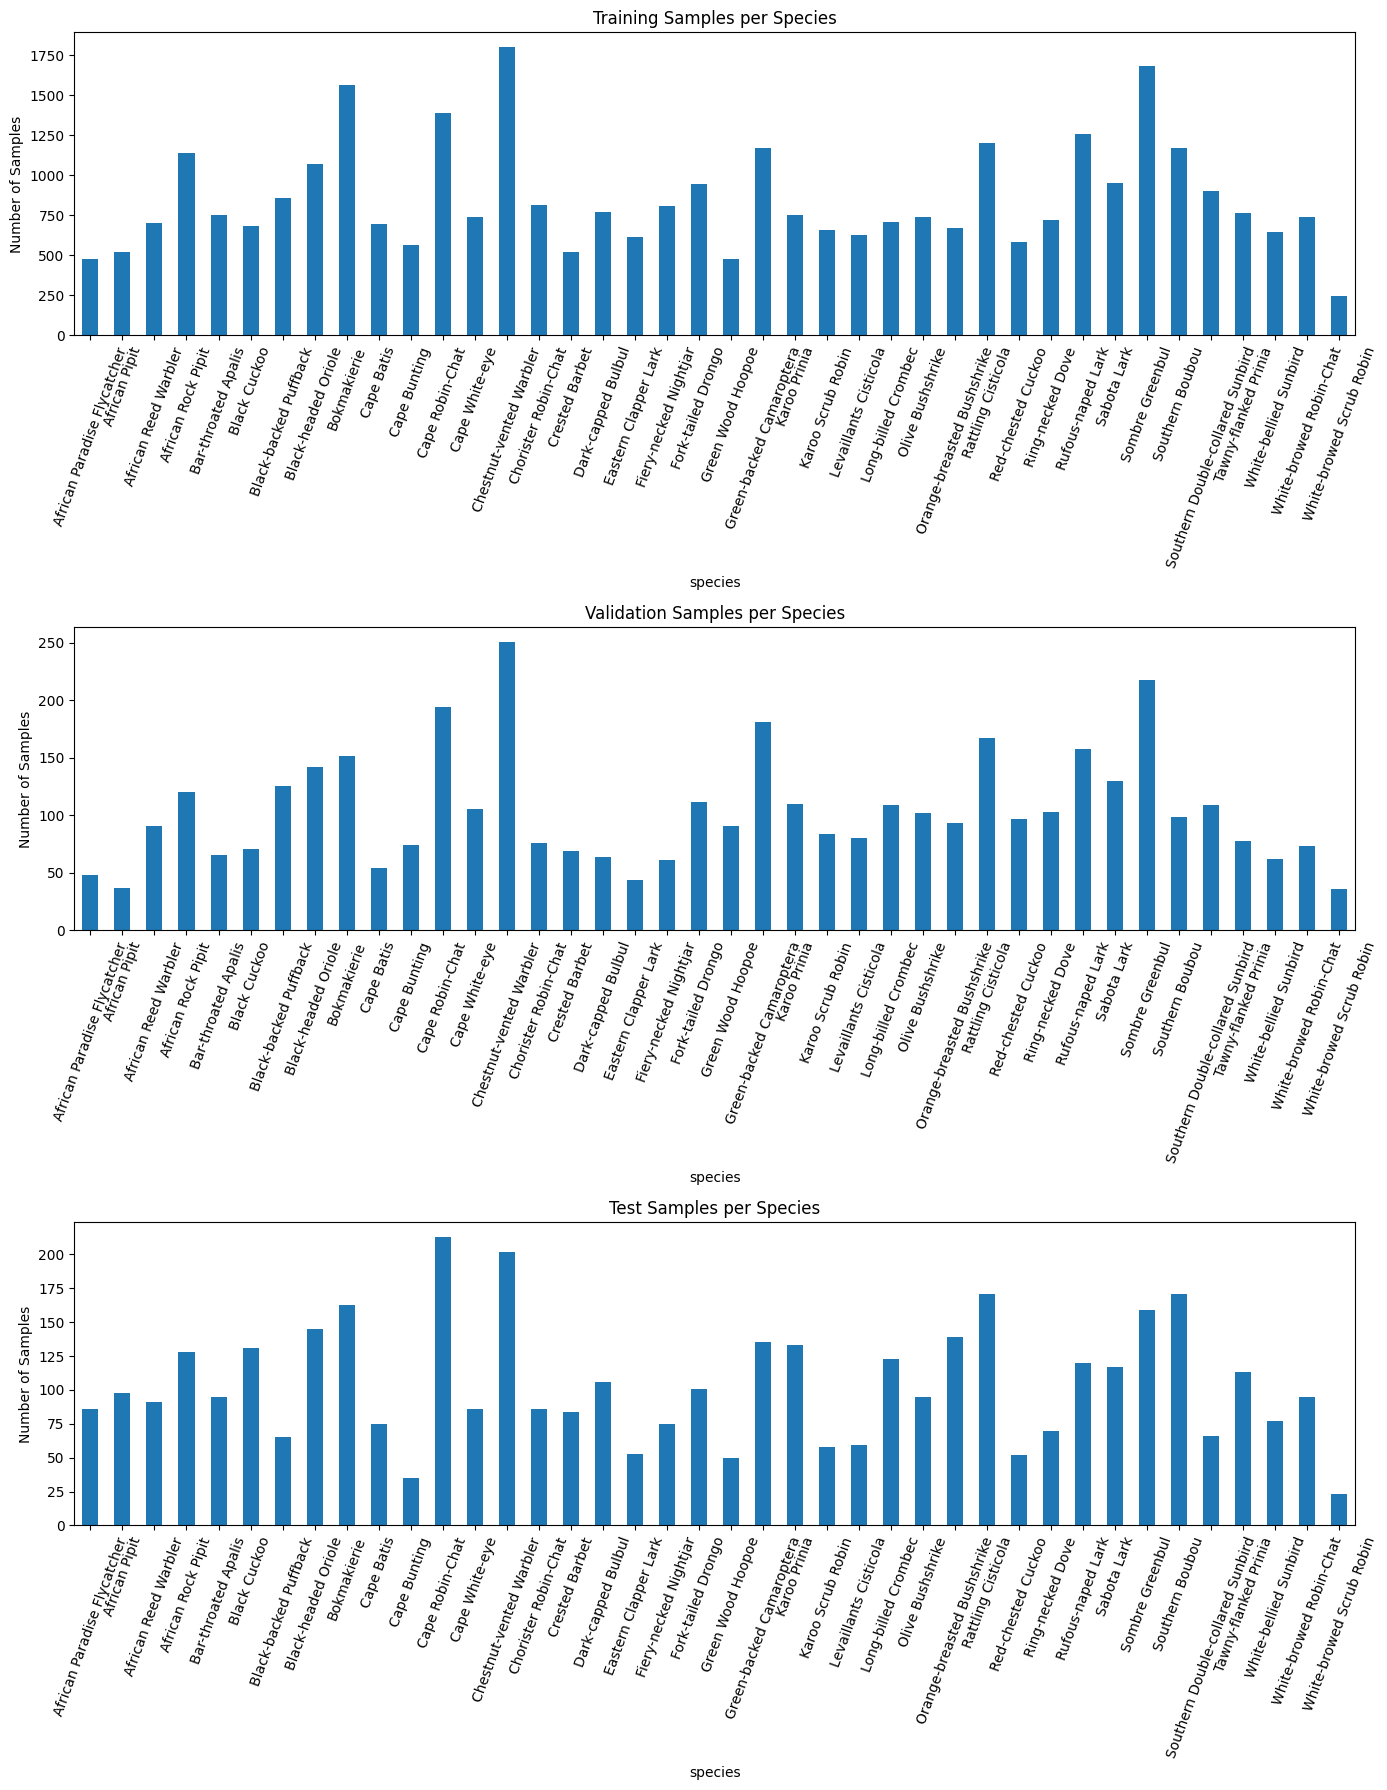

In [16]:
import matplotlib.pyplot as plt

# Set up the figure and axes
fig, axes = plt.subplots(3, 1, figsize=(14, 18))  # 3 rows, 1 column

splits = ['train', 'val', 'test']
titles = ['Training Samples per Species', 'Validation Samples per Species', 'Test Samples per Species']

for ax, split, title in zip(axes, splits, titles):
    # Group and count samples per species for the given split
    counts = metadata[metadata['split'] == split].groupby('species').size().reset_index(name='count')
    
    # Plot on the current axis
    counts.plot.bar(x='species', y='count', legend=False, ax=ax)
    ax.set_ylabel('Number of Samples')
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=70)
    
plt.tight_layout()
plt.show()
